### Import Library

In [1]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import cv2
import keras
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Data Preparation

In [2]:
# prompt: load data gambar dari drive mydrive\dataset

from google.colab import drive
drive.mount('/content/drive')

import os

# Assuming your image data is in a folder named 'dataset' inside 'MyDrive'
image_dir = '/content/drive/MyDrive/dataset'

# Check if the directory exists
if not os.path.exists(image_dir):
  print(f"Error: Directory '{image_dir}' not found.")
else:
  # List all files in the directory (you can adjust this to filter by specific extensions if needed)
  image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
  print(f"Found {len(image_files)} files in '{image_dir}'.")


Mounted at /content/drive
Found 0 files in '/content/drive/MyDrive/dataset'.


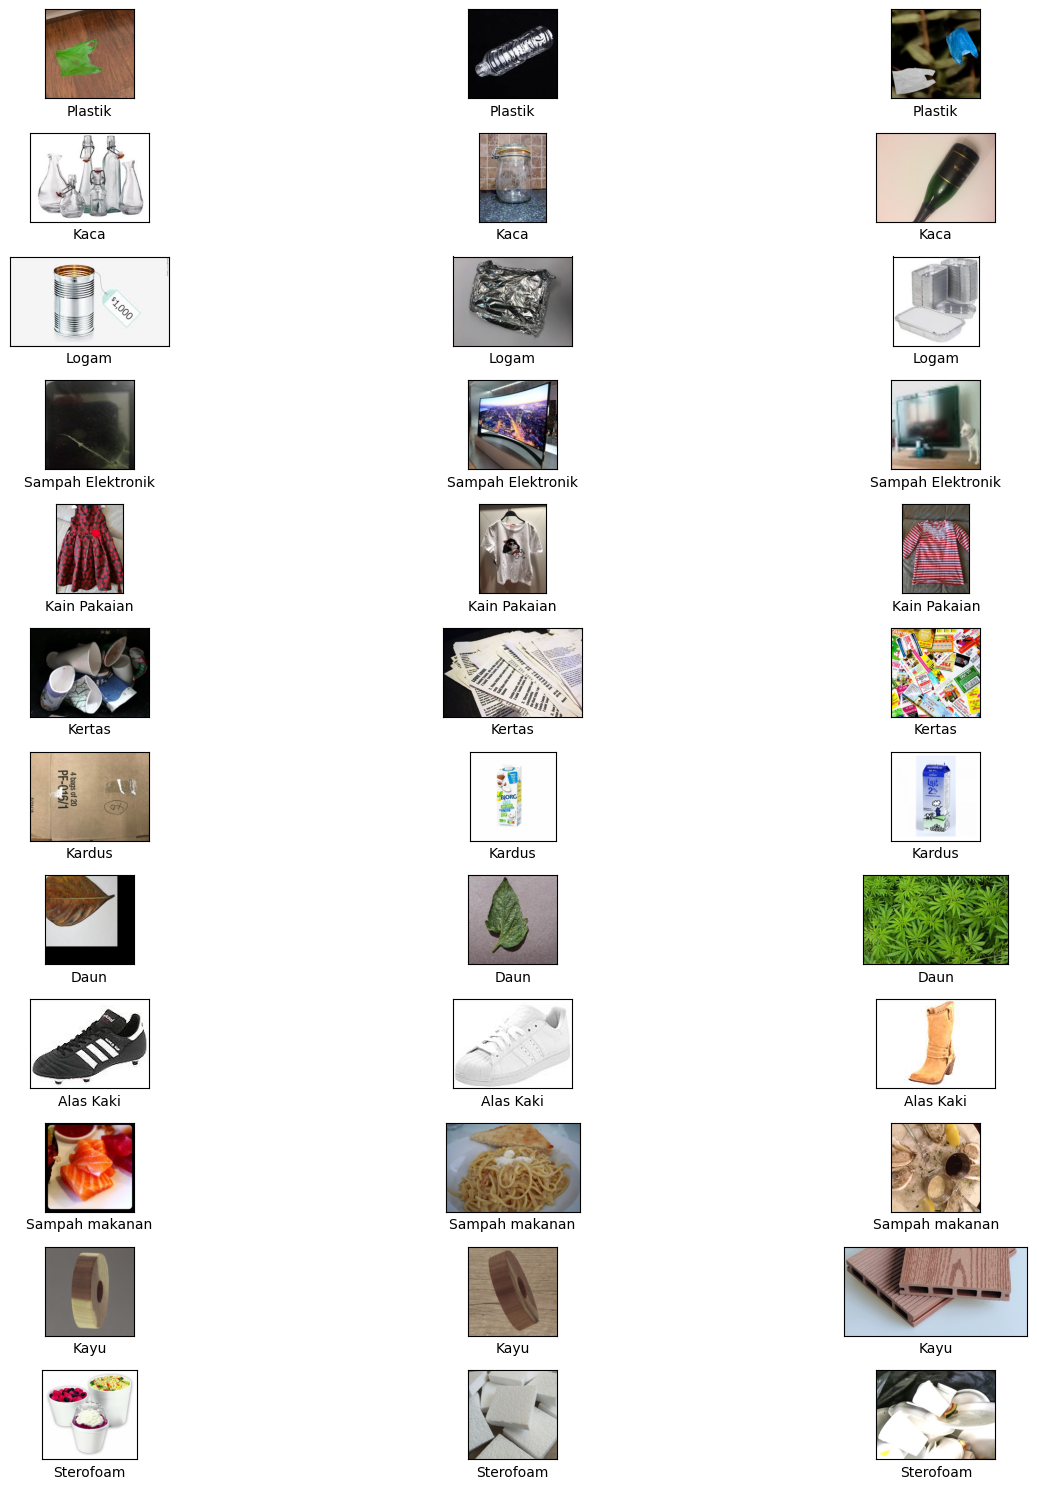

In [3]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

dataset_path = "/content/drive/MyDrive/dataset"

kamus_gambar = {}
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        kamus_gambar[class_name] = os.listdir(class_path)

# Menampilkan secara acak 3 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(kamus_gambar),3, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(dataset_path)):
    images = np.random.choice(kamus_gambar[class_name], 3, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(dataset_path, class_name, image_name)
        img = Image.open(img_path).convert("RGB")  # Tampilkan warna asli
        img = np.array(img)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()

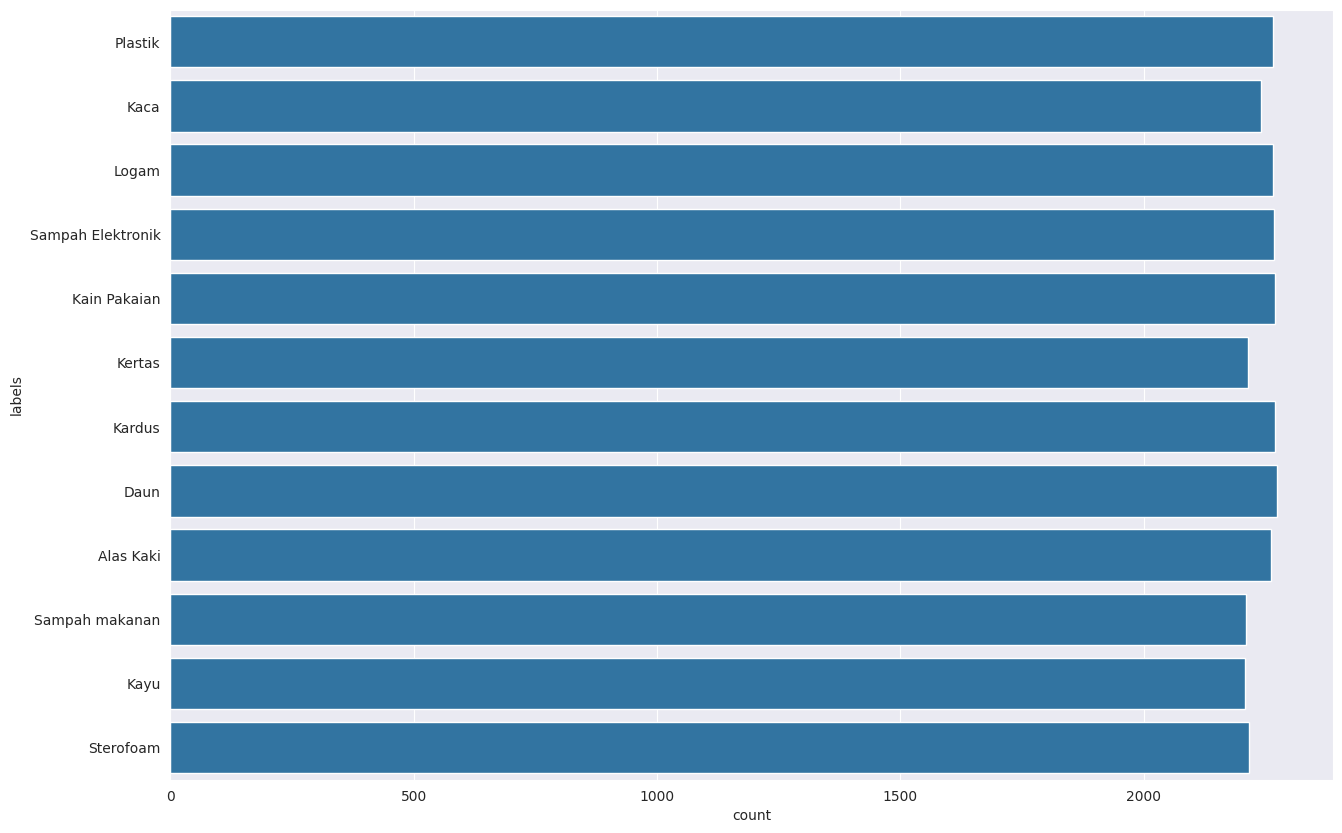

In [4]:
import seaborn as sns

full_path = []
labels = []
file_name = []

for path, subdirs, files in os.walk(dataset_path):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

distribution_train = pd.DataFrame({'path': full_path, 'labels': labels, 'file_name': file_name})

label = distribution_train['labels']
plt.figure(figsize=(15, 10))
sns.set_style('darkgrid')
sns.countplot(label)
plt.show()

In [5]:
full_path = []
labels = []
file_name = []

for path, subdirs, files in os.walk(dataset_path):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)
df = pd.DataFrame({'path': full_path, 'labels': labels, 'file_name': file_name})
df.groupby('labels').size()

,0
labels,
Alas Kaki,2261
Daun,2275
Kaca,2242
Kain Pakaian,2271
Kardus,2270
Kayu,2208
Kertas,2215
Logam,2266
Plastik,2266


In [6]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

In [8]:
from sklearn.model_selection import train_test_split

#Split dataset awal menjai data train, test, dan validasi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
#Membagi daaset awal menjadi tiga bagian, yaitu data pelatihan (train), data uji (test), dan validasi
df_train = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_test = pd.DataFrame({'path': X_test, 'labels': y_test, 'set':'test'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set' : 'val'})

In [10]:
print(f'Jumlah data train: {len(df_train)}')
print(f'Jumlah data validation: {len(df_val)}')
print(f'Jumlah data test: {len(df_test)}')

Jumlah data train: 17260
Jumlah data validation: 4315
Jumlah data test: 5394


In [11]:
#Gabungkan DataFrame df_train, df_test, df_val
df_all = pd.concat([df_train, df_test, df_val], ignore_index=True)

print('===================================================== \n')
display(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

set    labels           
test   Alas Kaki             467
       Daun                  397
       Kaca                  473
       Kain Pakaian          449
       Kardus                443
       Kayu                  443
       Kertas                462
       Logam                 451
       Plastik               438
       Sampah Elektronik     461
       Sampah makanan        463
       Sterofoam             447
train  Alas Kaki            1440
       Daun                 1433
       Kaca                 1445
       Kain Pakaian         1482
       Kardus               1447
       Kayu                 1393
       Kertas               1406
       Logam                1472
       Plastik              1489
       Sampah Elektronik    1428
       Sampah makanan       1384
       Sterofoam            1441
val    Alas Kaki             354
       Daun                  445
       Kaca                  324
       Kain Pakaian          340
       Kardus                380
       Kayu                  372
       Kertas                347
       Logam                 343
       Plastik               339
       Sampah Elektronik     379
       Sampah makanan        364
       Sterofoam             328
dtype: int64

'\n'

In [12]:
import os
import shutil
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import pandas as pd
import multiprocessing

# Folder tujuan akhir
final_dataset_path = "data-final"

# Gabungkan ketiga DataFrame menjadi satu
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

# Tambahkan kolom nama file
df_all['filename'] = df_all['path'].apply(lambda x: os.path.basename(x))

# Fungsi untuk menyalin satu file
def copy_file(row):
    src = row['path']
    dst_dir = os.path.join(final_dataset_path, row['set'], row['labels'])
    dst = os.path.join(dst_dir, row['filename'])

    try:
        os.makedirs(dst_dir, exist_ok=True)
        if not os.path.exists(dst):  # Hindari overwrite
            shutil.copyfile(src, dst)
    except Exception as e:
        print(f"Gagal salin {src} -> {dst} | Error: {e}")

# Jalankan penyalinan dengan ThreadPoolExecutor
if __name__ == '__main__':
    NUM_THREADS = multiprocessing.cpu_count() * 2
    rows = df_all.to_dict('records')
    with ThreadPoolExecutor(max_workers=NUM_THREADS) as executor:
        list(tqdm(executor.map(copy_file, rows), total=len(rows)))

print("Semua gambar berhasil disalin ke folder 'data-final'")


100%|██████████| 26969/26969 [37:31<00:00, 11.98it/s]

Semua gambar berhasil disalin ke folder 'data-final'


In [13]:
#Mendefinisikan direktori training, test, dan validasi
TRAIN_DIR = "data-final/train/"
TEST_DIR = "data-final/test/"
VAL_DIR = "data-final/val/"

In [14]:
train_plastik = os.path.join(TRAIN_DIR, 'Plastik')
train_kertas = os.path.join(TRAIN_DIR, 'Kertas')
train_alas_kaki = os.path.join(TRAIN_DIR, 'Alas Kaki')
train_kaca = os.path.join(TRAIN_DIR, 'Kaca')
train_daun = os.path.join(TRAIN_DIR, 'Daun')
train_kain_pakaian = os.path.join(TRAIN_DIR, 'Kain Pakaian')
train_kardus = os.path.join(TRAIN_DIR, 'Kardus')
train_kayu = os.path.join(TRAIN_DIR, 'Kayu')
train_logam = os.path.join(TRAIN_DIR, 'Logam')
train_sampah_elektronik = os.path.join(TRAIN_DIR, 'Sampah Elektronik')
train_sampah_makanan = os.path.join(TRAIN_DIR, 'Sampah makanan')
train_sterofoam = os.path.join(TRAIN_DIR, 'Sterofoam')

test_plastik = os.path.join(TEST_DIR, 'Plastik')
test_kertas = os.path.join(TEST_DIR, 'Kertas')
test_alas_kaki = os.path.join(TEST_DIR, 'Alas Kaki')
test_kaca = os.path.join(TEST_DIR, 'Kaca')
test_daun = os.path.join(TEST_DIR, 'Daun')
test_kain_pakaian = os.path.join(TEST_DIR, 'Kain Pakaian')
test_kardus = os.path.join(TEST_DIR, 'Kardus')
test_kayu = os.path.join(TEST_DIR, 'Kayu')
test_logam = os.path.join(TEST_DIR, 'Logam')
test_sampah_elektronik = os.path.join(TEST_DIR, 'Sampah Elektronik')
test_sampah_makanan = os.path.join(TEST_DIR, 'Sampah makanan')
test_sterofoam = os.path.join(TEST_DIR, 'Sterofoam')

val_plastik = os.path.join(VAL_DIR, 'Plastik')
val_kertas = os.path.join(VAL_DIR, 'Kertas')
val_alas_kaki = os.path.join(VAL_DIR, 'Alas Kaki')
val_kaca = os.path.join(VAL_DIR, 'Kaca')
val_daun = os.path.join(VAL_DIR, 'Daun')
val_kain_pakaian = os.path.join(VAL_DIR, 'Kain Pakaian')
val_kardus = os.path.join(VAL_DIR, 'Kardus')
val_kayu = os.path.join(VAL_DIR, 'Kayu')
val_logam = os.path.join(VAL_DIR, 'Logam')
val_sampah_elektronik = os.path.join(VAL_DIR, 'Sampah Elektronik')
val_sampah_makanan = os.path.join(VAL_DIR, 'Sampah makanan')
val_sterofoam = os.path.join(VAL_DIR, 'Sterofoam')


In [15]:
# Menghitung total gambar untuk setiap kategori dan direktori
print('total train Plastik images:', len(os.listdir(train_plastik)))
print('total train Kertas images:', len(os.listdir(train_kertas)))
print('total train Alas Kaki images:', len(os.listdir(train_alas_kaki)))
print('total train Kaca images:', len(os.listdir(train_kaca)))
print('total train Daun images:', len(os.listdir(train_daun)))
print('total train Kain Pakaian images:', len(os.listdir(train_kain_pakaian)))
print('total train Kardus images:', len(os.listdir(train_kardus)))
print('total train Kayu images:', len(os.listdir(train_kayu)))
print('total train Logam images:', len(os.listdir(train_logam)))
print('total train Sampah Elektronik images:', len(os.listdir(train_sampah_elektronik)))
print('total train Sampah makanan images:', len(os.listdir(train_sampah_makanan)))
print('total train Sterofoam images:', len(os.listdir(train_sterofoam)))

print('total test Plastik images:', len(os.listdir(test_plastik)))
print('total test Kertas images:', len(os.listdir(test_kertas)))
print('total test Alas Kaki images:', len(os.listdir(test_alas_kaki)))
print('total test Kaca images:', len(os.listdir(test_kaca)))
print('total test Daun images:', len(os.listdir(test_daun)))
print('total test Kain Pakaian images:', len(os.listdir(test_kain_pakaian)))
print('total test Kardus images:', len(os.listdir(test_kardus)))
print('total test Kayu images:', len(os.listdir(test_kayu)))
print('total test Logam images:', len(os.listdir(test_logam)))
print('total test Sampah Elektronik images:', len(os.listdir(test_sampah_elektronik)))
print('total test Sampah makanan images:', len(os.listdir(test_sampah_makanan)))
print('total test Sterofoam images:', len(os.listdir(test_sterofoam)))

print('total val Plastik images:', len(os.listdir(val_plastik)))
print('total val Kertas images:', len(os.listdir(val_kertas)))
print('total val Alas Kaki images:', len(os.listdir(val_alas_kaki)))
print('total val Kaca images:', len(os.listdir(val_kaca)))
print('total val Daun images:', len(os.listdir(val_daun)))
print('total val Kain Pakaian images:', len(os.listdir(val_kain_pakaian)))
print('total val Kardus images:', len(os.listdir(val_kardus)))
print('total val Kayu images:', len(os.listdir(val_kayu)))
print('total val Logam images:', len(os.listdir(val_logam)))
print('total val Sampah Elektronik images:', len(os.listdir(val_sampah_elektronik)))
print('total val Sampah makanan images:', len(os.listdir(val_sampah_makanan)))
print('total val Sterofoam images:', len(os.listdir(val_sterofoam)))

total train Plastik images: 1489
total train Kertas images: 1406
total train Alas Kaki images: 1440
total train Kaca images: 1445
total train Daun images: 1433
total train Kain Pakaian images: 1482
total train Kardus images: 1447
total train Kayu images: 1393
total train Logam images: 1472
total train Sampah Elektronik images: 1428
total train Sampah makanan images: 1384
total train Sterofoam images: 1441
total test Plastik images: 438
total test Kertas images: 462
total test Alas Kaki images: 467
total test Kaca images: 473
total test Daun images: 397
total test Kain Pakaian images: 449
total test Kardus images: 443
total test Kayu images: 443
total test Logam images: 451
total test Sampah Elektronik images: 461
total test Sampah makanan images: 463
total test Sterofoam images: 447
total val Plastik images: 339
total val Kertas images: 347
total val Alas Kaki images: 354
total val Kaca images: 324
total val Daun images: 445
total val Kain Pakaian images: 340
total val Kardus images: 3

In [16]:
# prompt: Simpan semua data hasil splitting ke zip dan unduh

# Kompres folder hasil splitting menjadi file zip
zip_filename = "data-final.zip"
shutil.make_archive(zip_filename.replace(".zip", ""), 'zip', final_dataset_path)

# Unduh file zip
from google.colab import files
files.download(zip_filename)

print(f"Folder '{final_dataset_path}' berhasil dikompres menjadi '{zip_filename}' dan siap diunduh.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Folder 'data-final' berhasil dikompres menjadi 'data-final.zip' dan siap diunduh.
